# Test 4
### Fit pixelated lens potential perturbations on a smooth SIE model and an elliptical Sérsic source.
The potential perturbation here is a single localised substructure on the Einstein ring.

__last update__: 21/07/21

In [1]:
# Basic imports
from time import time
import numpy as np
from scipy.optimize import minimize, Bounds, LinearConstraint
import matplotlib.pyplot as plt
from copy import deepcopy
import corner
%matplotlib inline

# Basic JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

# JAX-ified lenstronomy
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters
from jaxtronomy.Inference.loss import Loss
from jaxtronomy.Inference.optimization import Optimizer
from jaxtronomy.Inference.sampling import Sampler
from jaxtronomy.Util import image_util

# Universal font size
FS = 18

### Data grids (image plane and source plane)
For simplicity at first, assume both the smooth image plane and the source plane share the same pixelization.
Take the pixelated potential perturbations to live on a lower resolution grid (quarter-size).

In [2]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)

# Native image plane coordinates
x_grid, y_grid = pixel_grid.pixel_coordinates
x_coords = x_grid[0, :]
y_coords = y_grid[:, 0]
extent = [x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]]

# Lower resolution interpolation grid
npix_lowres = npix // 4
x_coords_lowres = np.linspace(extent[0], extent[1], npix_lowres)
y_coords_lowres = np.linspace(extent[2], extent[3], npix_lowres)
x_grid_lowres, y_grid_lowres = np.meshgrid(x_coords_lowres, y_coords_lowres)

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {extent[0], extent[1]} arcsec")
print(f"y range    : {extent[2], extent[3]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec


### Source light model

In [3]:
source_light_model_list = ['SERSIC_ELLIPSE']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'e1': -0.09, 'e2': 0.03,
                        'center_x': 0.4, 'center_y': 0.15}]

### Lens models (large-scale SIE + an SIE perturber)

In [4]:
# True lens mass model
true_lens_mass_model_list = ['SIE', 'SIE']
true_lens_mass_model = LensModel(true_lens_mass_model_list)
kwargs_true_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
                         {'theta_E': 0.25, 'e1': 0.0, 'e2': 0.0, 'center_x': 1.9, 'center_y': -0.4}]

# Hybrid lens mass model
hybrid_lens_mass_model_list = ['SIE', 'PIXELATED']
hybrid_lens_mass_model = LensModel(hybrid_lens_mass_model_list)

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

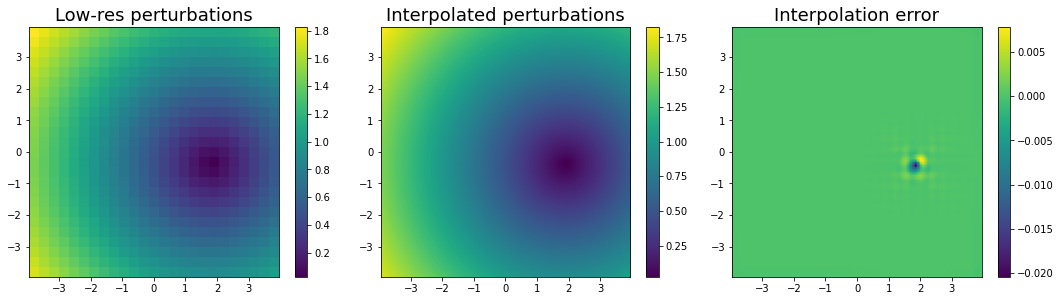

In [5]:
# Extract the true perturbation potential on original and low-res grids
psi_grid_true = true_lens_mass_model.potential(x_grid, y_grid, kwargs_true_lens_mass, k=1)
psi_grid_true_lowres = true_lens_mass_model.potential(x_grid_lowres, y_grid_lowres, kwargs_true_lens_mass, k=1)

# Set the hybrid lens mass model parameters
kwargs_hybrid_lens_mass = [kwargs_true_lens_mass[0],
                           {'x_coords': x_coords_lowres, 
                            'y_coords': y_coords_lowres, 
                            'psi_grid': psi_grid_true_lowres}]  # Transpose so that image_model works properly

# Test interpolating the low-res hybrid model to the original grid
psi_grid_interp = hybrid_lens_mass_model.potential(x_grid, y_grid, kwargs_hybrid_lens_mass, k=1).T

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
img1 = axes[0].imshow(psi_grid_true_lowres, origin='lower', extent=extent)
axes[0].set_title("Low-res perturbations", fontsize=FS)
img2 = axes[1].imshow(psi_grid_interp, origin='lower', extent=extent)
axes[1].set_title("Interpolated perturbations", fontsize=FS)
img3 = axes[2].imshow(psi_grid_true - psi_grid_interp, origin='lower', extent=extent)
axes[2].set_title("Interpolation error", fontsize=FS)
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

### PSF
Ignore the PSF for now.

In [6]:
kwargs_psf = {'psf_type': 'NONE', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)

### Noise

In [7]:
# Noise
exp_time = 100
sigma_bkd = 0.05
kwargs_noise = {'background_rms': sigma_bkd, 'exposure_time': exp_time}
noise = Noise(npix, npix, **kwargs_noise)
noise_hybrid = deepcopy(noise)

### Image model

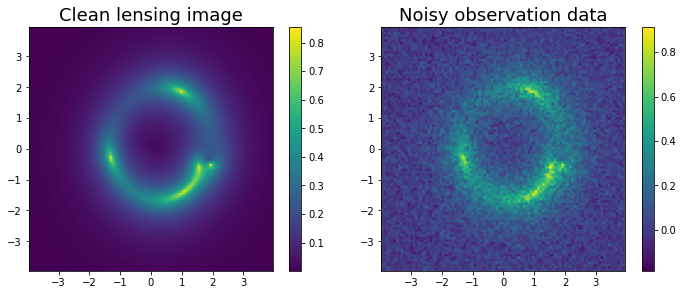

In [8]:
# Generate a lensed image based on source and lens models
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
lens_image = LensImage(pixel_grid, psf,
                       noise_class=noise,
                         lens_model_class=true_lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         kwargs_numerics=kwargs_numerics)

image = lens_image.model(kwargs_lens=kwargs_true_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light)


# Observed noisy data
data = lens_image.simulation(kwargs_lens=kwargs_true_lens_mass,
                             kwargs_source=kwargs_source_light,
                             kwargs_lens_light=kwargs_lens_light)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower', extent=extent)
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower', extent=extent)
ax2.set_title("Noisy observation data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

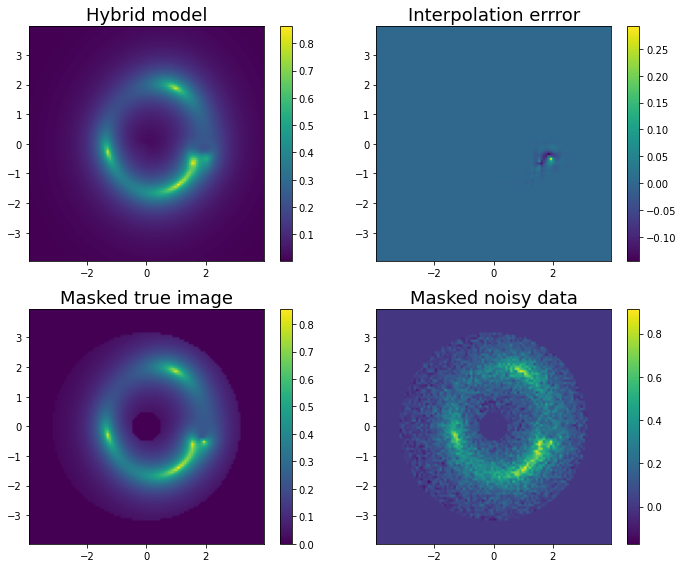

In [9]:
# Define a new noise class with true error map from the simulation above
kwargs_noise_hybrid = {'background_rms': sigma_bkd, 'noise_map': np.sqrt(lens_image.Noise.C_D)}
noise_hybrid = Noise(npix, npix, **kwargs_noise_hybrid)

# Hybrid image model for fitting
hybrid_lens_image = LensImage(pixel_grid, psf, noise_class=noise_hybrid,
                                lens_model_class=hybrid_lens_mass_model,
                                source_model_class=source_light_model,
                                lens_light_model_class=lens_light_model,
                                kwargs_numerics=kwargs_numerics)

# Test the hybrid model with the true low-res perturbation grid
hybrid_image = hybrid_lens_image.model(kwargs_lens=kwargs_hybrid_lens_mass,
                                        kwargs_source=kwargs_source_light,
                                        kwargs_lens_light=kwargs_lens_light)

# Generate a mask
rmin = 0.5
rmax = 3.2
# Original grid
radius = np.hypot(x_grid, y_grid)
mask = ((radius >= rmin) & (radius <= rmax)).astype(float)
# Low-res grid
radius_lowres = np.hypot(x_grid_lowres, y_grid_lowres)
mask_lowres = ((radius_lowres >= rmin) & (radius_lowres <= rmax)).astype(float)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
(ax1, ax2), (ax3, ax4) = axes
img1 = ax1.imshow(hybrid_image, origin='lower', extent=extent)
img2 = ax2.imshow(image - hybrid_image, origin='lower', extent=extent)
img3 = ax3.imshow(mask * image, origin='lower', extent=extent)
img4 = ax4.imshow(mask * data, origin='lower', extent=extent)
ax1.set_title("Hybrid model", fontsize=FS)
ax2.set_title("Interpolation errror", fontsize=FS)
ax3.set_title("Masked true image", fontsize=FS)
ax4.set_title("Masked noisy data", fontsize=FS)
for img, ax in zip((img1, img2, img3, img4), np.ravel(axes)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

## Fit the lens potential perturbation as a pixelated grid

### Parameters

Here we select which parameters to optimise, which one are fixed, lower/upper bounds (treated as "uniform" prior).

In [10]:
masked_lower = -10.*np.ones(npix_lowres**2)*mask_lowres.flatten()
masked_upper =  10.*np.ones(npix_lowres**2)*mask_lowres.flatten()

kwargs_model = {
    'lens_model_list': hybrid_lens_mass_model_list,
    'source_model_list': source_light_model_list,
    'lens_light_model_list': lens_light_model_list,
}
kwargs_init = {
    'kwargs_lens': [{}, {'psi_grid': np.zeros((npix_lowres, npix_lowres))}],
    'kwargs_source': [{}],
}
kwargs_prior = {
    #'kwargs_lens': [{}, {}],
    #'kwargs_lens': [{}, {'psi_grid': ['uniform', -np.inf, +np.inf]}],
    'kwargs_lens': [{}, {'psi_grid': ['uniform', masked_lower, masked_upper]}],
    'kwargs_source': [{}],
}
kwargs_fixed = {
    'kwargs_lens': [kwargs_hybrid_lens_mass[0], {'x_coords': x_coords_lowres, 'y_coords': y_coords_lowres}],
    'kwargs_source': kwargs_source_light,
}
parameters = Parameters(kwargs_model, kwargs_init, kwargs_prior, kwargs_fixed)

kwargs_true = {
    'kwargs_lens': kwargs_hybrid_lens_mass, 
    'kwargs_source': kwargs_source_light,
}
p_true = parameters.kwargs2args(kwargs_true)
print("truths:", len(p_true), parameters.names[0], parameters.names[-1])

print(parameters.prior_types[0])
#print(parameters.bounds)

truths: 625 dpsi_0 dpsi_624
uniform


#### Bounds for $\delta\psi$

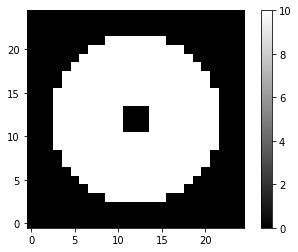

In [11]:
plt.imshow(parameters.bounds[1].reshape(npix_lowres, npix_lowres), origin='lower', cmap='gray')
plt.colorbar()
plt.show()

### Loss function
General loss function that takes all model input parameters as a nested dictionary of kwargs.

In [12]:
loss = Loss(data, hybrid_lens_image, parameters, prior_terms=['none'])

Check loss and gradient of the true parameters.

In [13]:
loss_true = loss(p_true)
print(f"loss: {loss_true:.2f}")
#print(f"grad(loss): {jax.jit(jax.grad(loss))(p_true)}")

#plt.imshow(np.sqrt(loss._image.Noise.C_D), origin='lower')
#plt.colorbar()
#plt.show()

loss: 6797.84


# Fit the perturbed pixelated potential

In [14]:
optimizer = Optimizer(loss, parameters)

best_fit, logL, extra_fields, runtime \
    = optimizer.minimize(method='BFGS', restart_from_init=True)
print(f"Runtime: {runtime}")
#print(extra_fields['result_class'])

Runtime: 18.493393898010254


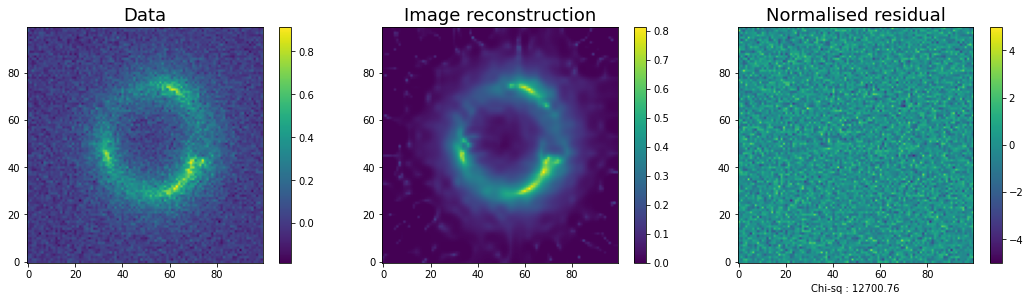

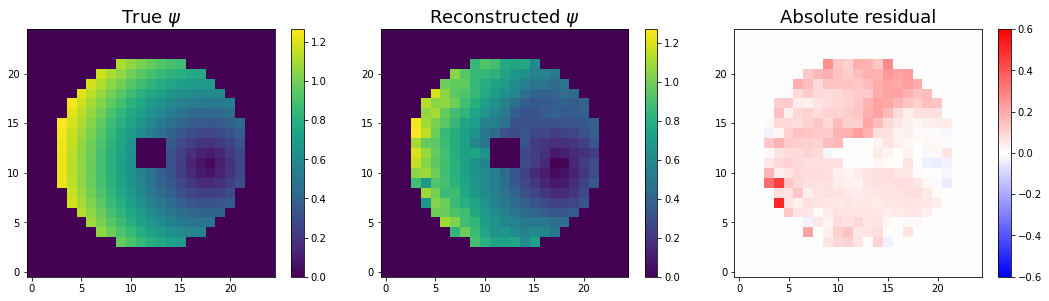

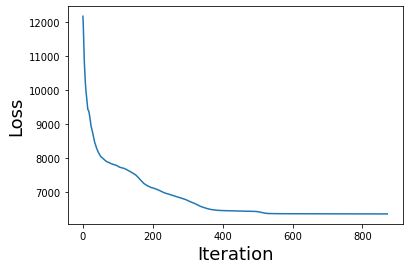

In [15]:
# create the resulting model image
kwargs_final = deepcopy(parameters.ML_values(as_kwargs=True))
rec_image = hybrid_lens_image.model(**kwargs_final)
noise_var = lens_image.Noise.C_D

# Reshape the final psi grid
psi_grid_rec = np.reshape(best_fit, (npix_lowres, npix_lowres))
psi_grid_rec_shifted = psi_grid_rec - (psi_grid_rec * mask_lowres).min()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax1, ax2, ax3 = axes
img1 = ax1.imshow(data, origin='lower')
ax1.set_title("Data", fontsize=FS)
img2 = ax2.imshow(rec_image, origin='lower')
ax2.set_title("Image reconstruction", fontsize=FS)
img3 = ax3.imshow((data - rec_image) / jnp.sqrt(noise_var), origin='lower', vmin=-5, vmax=5)
ax3.set_title("Normalised residual", fontsize=FS)
ax3.set_xlabel(f"Chi-sq : {2 * loss(best_fit):.2f}")
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ax1, ax2, ax3 = axes
img1 = ax1.imshow(psi_grid_true_lowres * mask_lowres, origin='lower')
ax1.set_title("True $\psi$", fontsize=FS)
img2 = ax2.imshow(psi_grid_rec_shifted * mask_lowres, origin='lower')
ax2.set_title("Reconstructed $\psi$", fontsize=FS)
img3 = ax3.imshow((psi_grid_true_lowres - psi_grid_rec_shifted) * mask_lowres, origin='lower', cmap='bwr', vmin=-0.6, vmax=0.6)
ax3.set_title("Absolute residual", fontsize=FS)
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

fig, ax = plt.subplots(1, 1)
ax.plot(range(len(optimizer.loss_history)), optimizer.loss_history)
ax.set_ylabel("Loss", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS);

Using approximated inverse Hessian


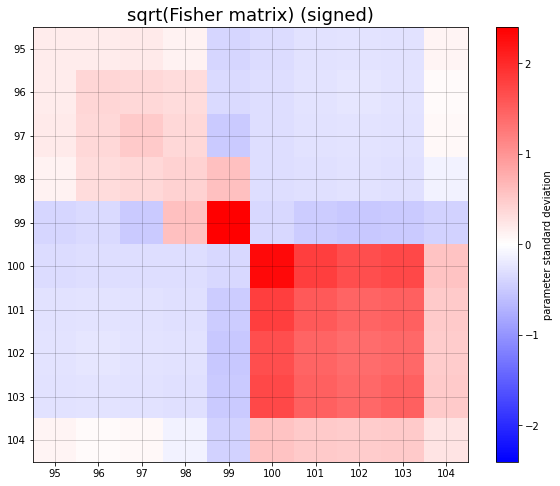

In [16]:
fisher_matrix = None

if extra_fields['hess_inv'] is not None:
    print("Using approximated inverse Hessian")
    fisher_matrix = extra_fields['hess_inv']
    
    imin, imax = 95, 105
    
    best_fit_red = best_fit[imin:imax]
    fisher_matrix_red = fisher_matrix[imin:imax, imin:imax]
    p_true_red = p_true[imin:imax]
    symbols_red = parameters.symbols[imin:imax]
    
    sqrt_fisher_matrix_red_signed = np.sqrt(np.abs(fisher_matrix_red)) * np.sign(fisher_matrix_red)
    
    plt.figure(figsize=(10, 8))
    plt.title("sqrt(Fisher matrix) (signed)", fontsize=FS)
    plt.imshow(sqrt_fisher_matrix_red_signed, cmap='bwr', vmin=-np.abs(sqrt_fisher_matrix_red_signed).max(), vmax=np.abs(sqrt_fisher_matrix_red_signed).max())
    plt.colorbar(label="parameter standard deviation")
    plt.gca().set_xticks(np.arange(0, imax-imin))
    plt.gca().set_xticklabels(np.arange(imin, imax))
    plt.gca().set_yticks(np.arange(0, imax-imin))
    plt.gca().set_yticklabels(np.arange(imin, imax))
    plt.grid('on', color='black', alpha=0.2)
    plt.show()

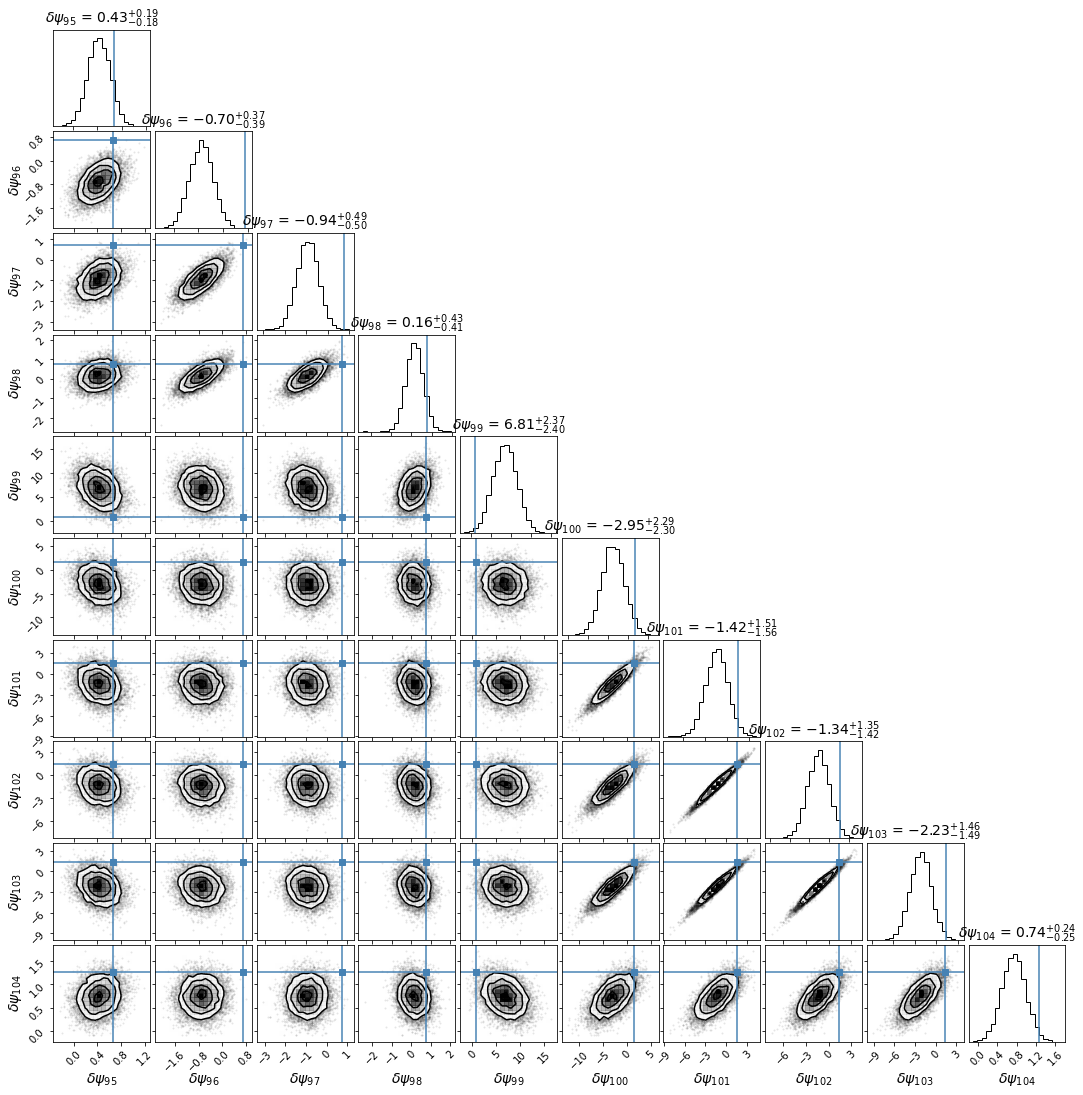

In [17]:
def draw_from_gaussian(mu, S, ndraws=1):
    ndim = len(mu)
    r = np.random.multivariate_normal(mu, S, size=ndraws)
    return r

if fisher_matrix is not None:
    samples_fisher = draw_from_gaussian(best_fit_red, fisher_matrix_red, ndraws=10000)

    fig = plt.figure(figsize=(15, 15))
    fig = corner.corner(samples_fisher, truths=p_true_red, show_titles=True, labels=symbols_red,
                        fig=fig, title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14})
    plt.show()

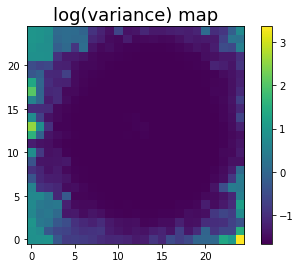

In [18]:
if fisher_matrix is not None:
    cov_diag = np.abs(np.diag(fisher_matrix))
    variance_map = cov_diag.reshape((npix_lowres, npix_lowres))
    
    plt.title("log(variance) map", fontsize=FS)
    plt.imshow(np.log10(variance_map), origin='lower')
    plt.colorbar()
    plt.show()